# Libraries

In [1]:
import math
import pandas as pd
import numpy as np

import os

import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.pylab import rcParams
rcParams['figure.figsize']=20,10



In [2]:
from keras.optimizers import RMSprop
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional,GRU,SimpleRNN

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix

# DATASET creation and data visualization

In [3]:
def get_company_dataset(company_name):
    df=pd.read_csv('symbols_valid_meta.csv')
    if 'Y' in str(df.loc[df['Symbol'] == company_name]['ETF'].to_numpy()):
        #open etfs
        return pd.read_csv("etfs\\"+company_name+".csv")
    else:
        return pd.read_csv("stocks\\"+company_name+".csv")

In [4]:
df=get_company_dataset(company_name="AAU")
print(df.info(),'\t\t',df.shape)
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3594 entries, 0 to 3593
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       3594 non-null   object 
 1   Open       3594 non-null   float64
 2   High       3594 non-null   float64
 3   Low        3594 non-null   float64
 4   Close      3594 non-null   float64
 5   Adj Close  3594 non-null   float64
 6   Volume     3594 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 196.7+ KB
None 		 (3594, 7)


,Date,Open,High,Low,Close,Adj Close,Volume
0,2005-12-20,1.62,1.64,1.60,1.63,1.63,14100
1,2005-12-21,1.63,1.79,1.62,1.67,1.67,46500
2,2005-12-22,1.70,1.81,1.70,1.74,1.74,63200
3,2005-12-23,1.79,2.15,1.79,2.00,2.00,130400
4,2005-12-27,2.00,2.27,2.00,2.24,2.24,95500


In [5]:
df_plot = df.copy()

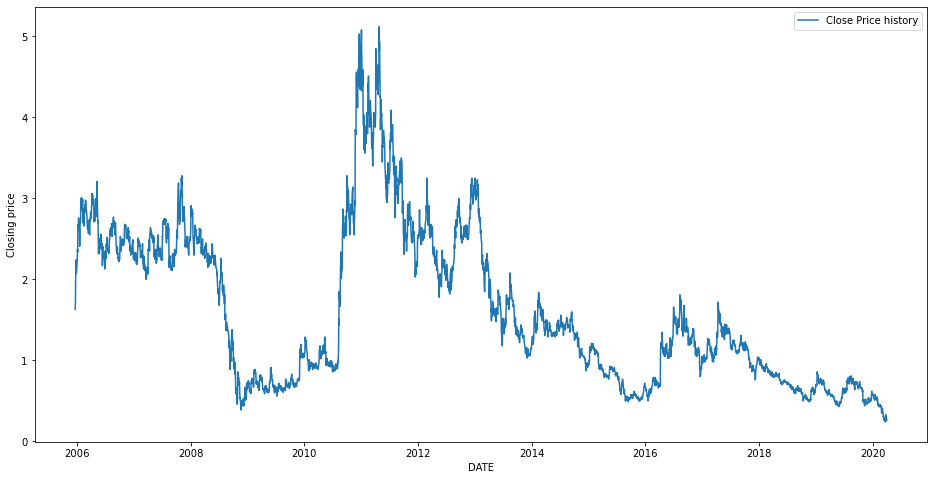

In [6]:
df_plot["Date"]=pd.to_datetime(df_plot.Date,format="%Y-%m-%d")
df_plot.index=df_plot['Date']
plt.figure(figsize=(16,8))
plt.plot(df_plot["Close"],label='Close Price history')
plt.xlabel('DATE')
plt.ylabel("Closing price")
plt.legend()


## Analyse, Filter and Normalize the data
## Choosen feature = 'Open', 'High', 'Low', 'Volume', 'Close'


In [7]:
df = df.dropna()
df.drop("Date",axis=1,inplace=True)
df.drop("Adj Close",axis=1,inplace=True)
df.head()

,Open,High,Low,Close,Volume
0,1.62,1.64,1.60,1.63,14100
1,1.63,1.79,1.62,1.67,46500
2,1.70,1.81,1.70,1.74,63200
3,1.79,2.15,1.79,2.00,130400
4,2.00,2.27,2.00,2.24,95500


In [8]:
new_cols = df.columns.to_list()
new_cols.append(new_cols.pop(new_cols.index('Close')))
new_cols

df=df.reindex(columns=new_cols)
df.head()

,Open,High,Low,Volume,Close
0,1.62,1.64,1.60,14100,1.63
1,1.63,1.79,1.62,46500,1.67
2,1.70,1.81,1.70,63200,1.74
3,1.79,2.15,1.79,130400,2.00
4,2.00,2.27,2.00,95500,2.24


In [9]:
scaler = MinMaxScaler(feature_range=(0, 1))
df[['Open', 'High', 'Low', 'Volume', 'Close']] = scaler.fit_transform(df[['Open', 'High', 'Low', 'Volume', 'Close']])
df[0:31]

,Open,High,Low,Volume,Close
0,0.285132,0.272549,0.304825,0.001696,0.284836
1,0.287169,0.301961,0.309211,0.008010,0.293033
2,0.301426,0.305882,0.326754,0.011265,0.307377
3,0.319756,0.372549,0.346491,0.024362,0.360656
4,0.362525,0.396078,0.392544,0.017560,0.409836
5,0.411405,0.398039,0.410088,0.026818,0.377049
6,0.403259,0.390196,0.403509,0.020250,0.387295
7,0.401222,0.380392,0.410088,0.016664,0.389344
8,0.405295,0.409804,0.418860,0.042332,0.415984
9,0.423625,0.417647,0.453947,0.067805,0.436475


## Split and Create dataset for training and testing 

In [10]:
# splits the dataset into : Training and Testing dataset
def split_dataset(dataset, ratio=0.8):
    split_index = int(ratio * dataset.shape[0])
    train_data = dataset.iloc[0:split_index,:]
    valid_data = dataset.iloc[split_index:,:]
    
    return train_data,valid_data

In [11]:
# Creates the training data and testing data to train and test the data
# creates the x_data of shape: (timestep*features) .i.e, 30*5
# creates the y_data of shape: (number of data) .i.e, 1
def  create_dataset(data,timestep=1):
    x_data,y_data=[],[]

    for i in range(len(data)-timestep-1):
        x_data.append(data.iloc[i:i+timestep,:])
        y_data.append(data.iloc[i+timestep,-1])

    return np.array(x_data),np.array(y_data)[:,np.newaxis]

In [12]:
# Split the data into training and testing dataset
train_data,test_data = split_dataset(df)
print(f'Training data shape : {train_data.shape}\nTesting data shape: {test_data.shape}')

Training data shape : (2875, 5)
Testing data shape: (719, 5)


In [13]:
time_step = 30
x_train,y_train = create_dataset(train_data, time_step)
x_test,y_test = create_dataset(test_data, time_step)
print(f"X_train shape : {x_train.shape} \t Y_train shape :{y_train.shape}")
print(f"X_test shape : {x_test.shape} \t Y_test shape :{y_test.shape}")

X_train shape : (2844, 30, 5) 	 Y_train shape :(2844, 1)
X_test shape : (688, 30, 5) 	 Y_test shape :(688, 1)


In [14]:
vald_index = int(x_train.shape[0]*0.8)
vald_index

2275

In [15]:
# x_valid,y_valid = x_train[vald_index:],x_train[vald_index:]
# x_train,y_train =  x_train[:vald_index],x_train[:vald_index]

# 1st model :LSTM MODULE 

In [16]:
def final_model(X:np.array,y:np.array,learn_rate:float,dropout:float):
    model = Sequential()
    model.add(LSTM(X.shape[1],return_sequences=False))
    model.add(Dense(X.shape[1]))
    model.add(Dropout(dropout))
    model.add(Dense(y.shape[1],activation='tanh'))
    optimizer = RMSprop(learning_rate=learn_rate)
    model.compile(loss='mean_squared_error',optimizer=optimizer)
    return model

In [17]:
model1 = final_model(x_train,y_train,0.01,0.2)


In [18]:
history1 = model1.fit(x_train,y_train,epochs=30,batch_size=5,verbose=2,validation_data=(x_test,y_test))
model1.summary()

Epoch 1/30
569/569 - 23s - loss: 0.0053 - val_loss: 3.0327e-04 - 23s/epoch - 40ms/step
Epoch 2/30
569/569 - 14s - loss: 0.0021 - val_loss: 0.0039 - 14s/epoch - 25ms/step
Epoch 3/30
569/569 - 14s - loss: 0.0019 - val_loss: 0.0017 - 14s/epoch - 25ms/step
Epoch 4/30
569/569 - 15s - loss: 0.0017 - val_loss: 3.6280e-04 - 15s/epoch - 26ms/step
Epoch 5/30
569/569 - 14s - loss: 0.0017 - val_loss: 6.3190e-04 - 14s/epoch - 25ms/step
Epoch 6/30
569/569 - 14s - loss: 0.0016 - val_loss: 0.0024 - 14s/epoch - 25ms/step
Epoch 7/30
569/569 - 14s - loss: 0.0017 - val_loss: 8.7492e-04 - 14s/epoch - 25ms/step
Epoch 8/30
569/569 - 14s - loss: 0.0016 - val_loss: 4.7396e-04 - 14s/epoch - 25ms/step
Epoch 9/30
569/569 - 14s - loss: 0.0016 - val_loss: 7.0018e-05 - 14s/epoch - 25ms/step
Epoch 10/30
569/569 - 14s - loss: 0.0015 - val_loss: 3.6021e-05 - 14s/epoch - 25ms/step
Epoch 11/30
569/569 - 14s - loss: 0.0014 - val_loss: 1.6076e-04 - 14s/epoch - 25ms/step
Epoch 12/30
569/569 - 14s - loss: 0.0015 - val_loss: 

dict_keys(['loss', 'val_loss'])


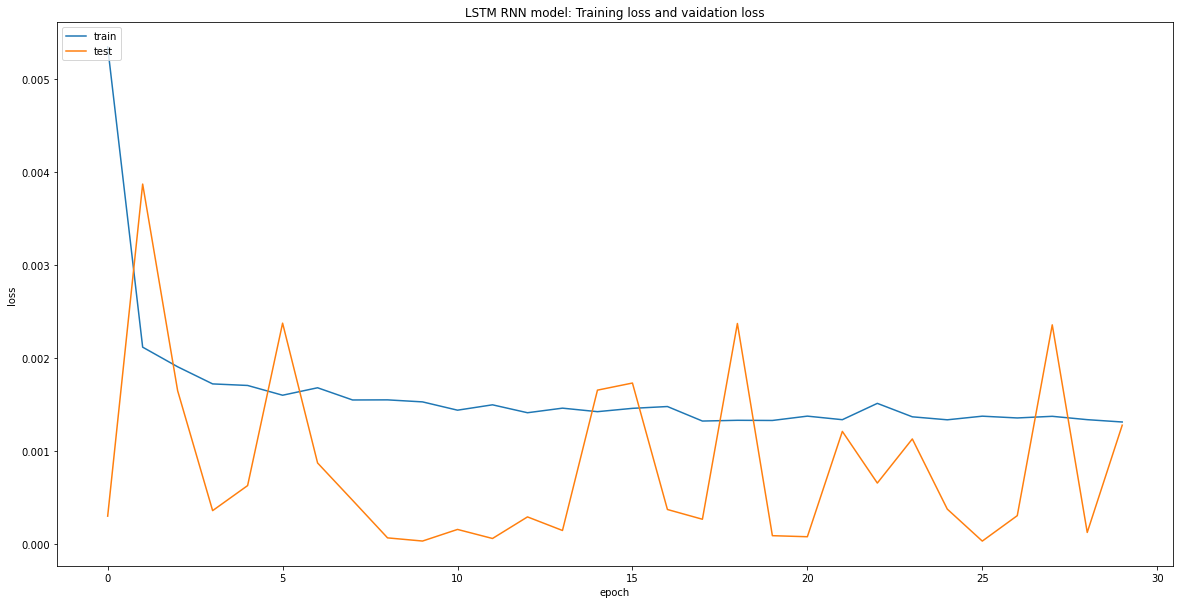

In [19]:

print(history1.history.keys())
# summarize history for loss
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('LSTM RNN model: Training loss and vaidation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [20]:
train_predicted_closing_price_model1 = model1.predict(x_train)
math.sqrt(mean_squared_error(y_train,train_predicted_closing_price_model1))

89/89 [==============================] - 2s 7ms/step


0.04727990652074735

In [21]:
test_predicted_closing_price_model1=model1.predict(x_test)
math.sqrt(mean_squared_error(y_test,test_predicted_closing_price_model1))

22/22 [==============================] - 0s 7ms/step


0.03578997133852011

In [22]:
x_test.shape,test_predicted_closing_price_model1.shape

((688, 30, 5), (688, 1))

In [23]:
train_predicted_closing_price_model1.shape,train_data.shape,type(train_predicted_closing_price_model1)

((2844, 1), (2875, 5), numpy.ndarray)

In [24]:
train_predict_plot = np.empty_like(df['Close'])[:,np.newaxis]
train_predict_plot[:]=np.nan
train_predict_plot[time_step:train_predicted_closing_price_model1.shape[0]+time_step]=train_predicted_closing_price_model1[np.newaxis,:]
train_predict_plot[time_step:train_predicted_closing_price_model1.shape[0]+time_step]

array([[0.47904557],
       [0.46880928],
       [0.4803476 ],
       ...,
       [0.23261745],
       [0.22360364],
       [0.22485848]])

In [25]:
test_predict_plot = np.empty_like(df['Close'])[:,np.newaxis]
test_predict_plot[:]=np.nan
test_predicted_closing_price_model1.shape,test_data.shape[0]+train_data.shape[0]
test_predict_plot[train_data.shape[0]+time_step:-1]=test_predicted_closing_price_model1[np.newaxis,:]
# test_predict_plot[time_step:test_predicted_closing_price_model1.shape[0]+time_step]

In [26]:

df['train_predicted']=train_predict_plot
df['test_predicted']=test_predict_plot


In [27]:
df

,Open,High,Low,Volume,Close,train_predicted,test_predicted
0,0.285132,0.272549,0.304825,0.001696,0.284836,NaN,NaN
1,0.287169,0.301961,0.309211,0.008010,0.293033,NaN,NaN
2,0.301426,0.305882,0.326754,0.011265,0.307377,NaN,NaN
3,0.319756,0.372549,0.346491,0.024362,0.360656,NaN,NaN
4,0.362525,0.396078,0.392544,0.017560,0.409836,NaN,NaN
...,...,...,...,...,...,...,...
3589,0.022403,0.015686,0.013158,0.118420,0.008197,NaN,0.074714
3590,0.012220,0.015686,0.015351,0.038317,0.012295,NaN,0.065929
3591,0.018330,0.013725,0.015351,0.085852,0.008197,NaN,0.066534
3592,0.012220,0.007843,0.015351,0.041045,0.008197,NaN,0.065799


## LSTM model : Predicted stock price vs True stock price comparision

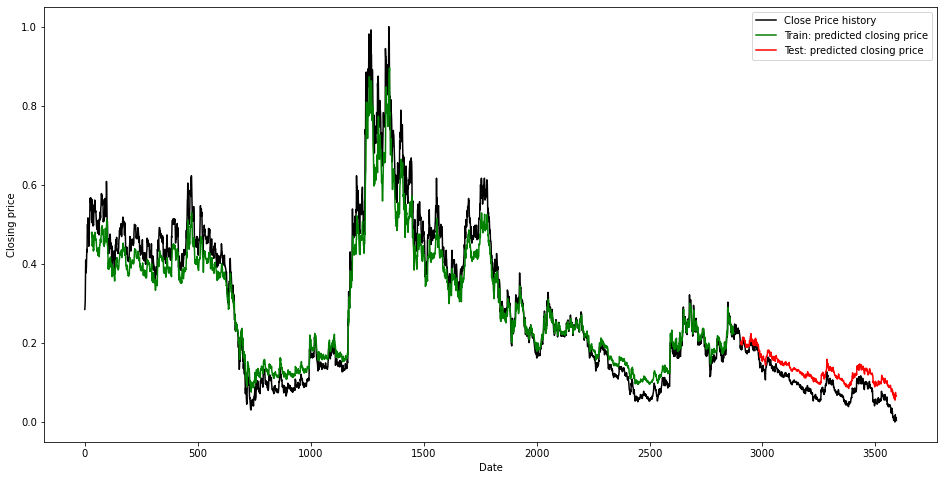

In [28]:
plt.figure(figsize=(16,8))
plt.plot(df["Close"],label='Close Price history',color='black')
plt.plot(df['train_predicted'],color="green",label='Train: predicted closing price')
plt.plot(df['test_predicted'],color="red",label='Test: predicted closing price')

plt.xlabel("Date");
plt.ylabel("Closing price"); 
plt.legend();

## 2nd Model : Bidirectional LSTM

In [29]:
def final_model1(X:np.array,y:np.array,learn_rate:float,dropout:float):
    model = Sequential()
    model.add(Bidirectional(LSTM(X.shape[1],return_sequences=True),input_shape=(X.shape[1:])))
    model.add(Bidirectional(LSTM(X.shape[1],return_sequences=True)))
    model.add(Bidirectional(LSTM(X.shape[1])))
    model.add(Dense(X.shape[1]))
    model.add(Dropout(dropout))
    model.add(Dense(y.shape[1],activation='tanh'))
    optimizer = RMSprop(learning_rate=learn_rate)
    model.compile(loss='mean_squared_error',optimizer=optimizer)
    return model

In [30]:
model2 = final_model(x_train,y_train,0.01,0.2)
# model2.summary()

In [31]:

history2 = model2.fit(x_train,y_train,validation_data=(x_test, y_test),epochs=30,batch_size=5,verbose=2)


Epoch 1/30
569/569 - 22s - loss: 0.0056 - val_loss: 4.1346e-04 - 22s/epoch - 39ms/step
Epoch 2/30
569/569 - 15s - loss: 0.0021 - val_loss: 1.4130e-04 - 15s/epoch - 26ms/step
Epoch 3/30
569/569 - 15s - loss: 0.0018 - val_loss: 0.0012 - 15s/epoch - 26ms/step
Epoch 4/30
569/569 - 15s - loss: 0.0017 - val_loss: 5.6210e-05 - 15s/epoch - 26ms/step
Epoch 5/30
569/569 - 15s - loss: 0.0017 - val_loss: 2.8260e-04 - 15s/epoch - 26ms/step
Epoch 6/30
569/569 - 14s - loss: 0.0015 - val_loss: 4.3448e-05 - 14s/epoch - 25ms/step
Epoch 7/30
569/569 - 14s - loss: 0.0016 - val_loss: 0.0014 - 14s/epoch - 25ms/step
Epoch 8/30
569/569 - 15s - loss: 0.0015 - val_loss: 5.7233e-05 - 15s/epoch - 26ms/step
Epoch 9/30
569/569 - 14s - loss: 0.0015 - val_loss: 3.6956e-04 - 14s/epoch - 25ms/step
Epoch 10/30
569/569 - 15s - loss: 0.0015 - val_loss: 1.1028e-04 - 15s/epoch - 26ms/step
Epoch 11/30
569/569 - 15s - loss: 0.0015 - val_loss: 2.4372e-04 - 15s/epoch - 27ms/step
Epoch 12/30
569/569 - 15s - loss: 0.0014 - val_lo

dict_keys(['loss', 'val_loss'])


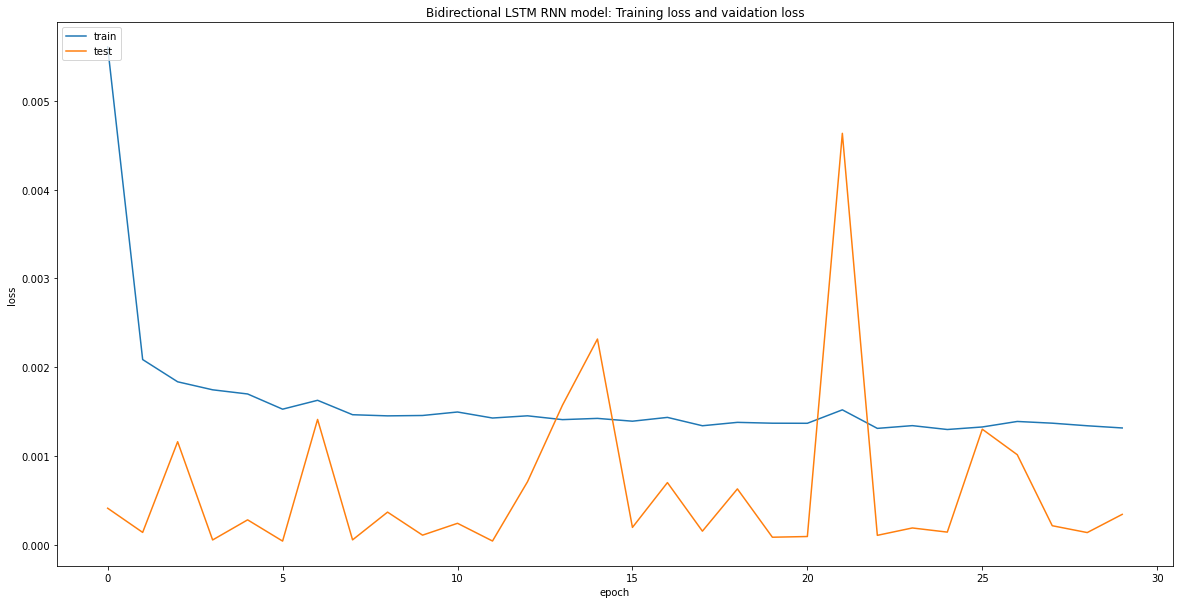

In [32]:

print(history2.history.keys())
# summarize history for loss
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Bidirectional LSTM RNN model: Training loss and vaidation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [33]:
train_predicted_closing_price_model2 = model2.predict(x_train)
math.sqrt(mean_squared_error(y_train,train_predicted_closing_price_model2))

89/89 [==============================] - 2s 7ms/step


0.02770595251735511

In [34]:
test_predicted_closing_price_model2=model2.predict(x_test)
math.sqrt(mean_squared_error(y_test,test_predicted_closing_price_model2))

22/22 [==============================] - 0s 8ms/step


0.018557149368488058

In [35]:
train_predict_plot = np.empty_like(df['Close'])[:,np.newaxis]
train_predict_plot[:]=np.nan
train_predict_plot[time_step:train_predicted_closing_price_model2.shape[0]+time_step]=train_predicted_closing_price_model2[np.newaxis,:]
train_predict_plot[time_step:train_predicted_closing_price_model2.shape[0]+time_step]

test_predict_plot = np.empty_like(df['Close'])[:,np.newaxis]
test_predict_plot[:]=np.nan
test_predicted_closing_price_model2.shape,test_data.shape[0]+train_data.shape[0]
test_predict_plot[train_data.shape[0]+time_step:-1]=test_predicted_closing_price_model2[np.newaxis,:]
# test_predict_plot[time_step:test_predicted_closing_price_model1.shape[0]+time_step]


df['train_predicted1']=train_predict_plot
df['test_predicted1']=test_predict_plot


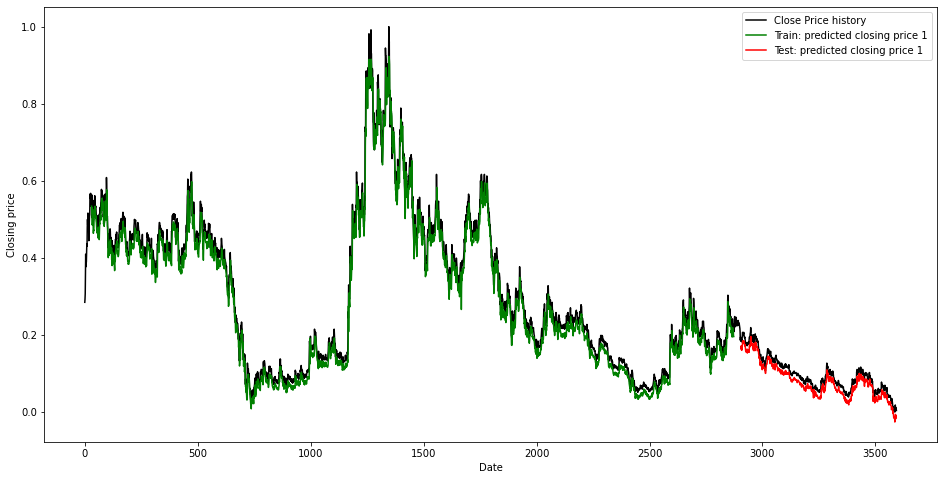

In [36]:
plt.figure(figsize=(16,8))
plt.plot(df["Close"],label='Close Price history',color='black')
# plt.plot(df['train_predicted'],color="green",label='Train: predicted closing price')
# plt.plot(df['test_predicted'],color="red",label='Test: predicted closing price')

plt.plot(df['train_predicted1'],color="green",label='Train: predicted closing price 1')
plt.plot(df['test_predicted1'],color="red",label='Test: predicted closing price 1')

plt.xlabel("Date");
plt.ylabel("Closing price"); 
plt.legend();

## 3rd model: GRU Model

In [37]:
def GRU_model(X:np.array,y:np.array,learn_rate:float,dropout:float):
    model = Sequential()
    model.add(GRU(X.shape[1],return_sequences=True))
    model.add(GRU(X.shape[1],return_sequences=True))
    model.add(GRU(X.shape[1]))
    model.add(Dense(X.shape[1]))
    model.add(Dropout(dropout))
    model.add(Dense(y.shape[1],activation='tanh'))
    optimizer = RMSprop(learning_rate=learn_rate)
    model.compile(loss='mean_squared_error',optimizer=optimizer)
    return model

gru_model = GRU_model(x_train,y_train,0.01,0.2)


In [38]:
# gru_model.summary()

In [39]:
gru_history = gru_model.fit(x_train,y_train,validation_data=(x_test, y_test),epochs=30,batch_size=5,verbose=2)


Epoch 1/30
569/569 - 65s - loss: 0.0106 - val_loss: 2.9511e-04 - 65s/epoch - 115ms/step
Epoch 2/30
569/569 - 46s - loss: 0.0036 - val_loss: 4.8054e-04 - 46s/epoch - 81ms/step
Epoch 3/30
569/569 - 46s - loss: 0.0030 - val_loss: 0.0018 - 46s/epoch - 81ms/step
Epoch 4/30
569/569 - 46s - loss: 0.0027 - val_loss: 5.0580e-04 - 46s/epoch - 82ms/step
Epoch 5/30
569/569 - 47s - loss: 0.0027 - val_loss: 2.6090e-04 - 47s/epoch - 82ms/step
Epoch 6/30
569/569 - 44s - loss: 0.0059 - val_loss: 0.0011 - 44s/epoch - 77ms/step
Epoch 7/30
569/569 - 47s - loss: 0.0099 - val_loss: 0.0091 - 47s/epoch - 82ms/step
Epoch 8/30
569/569 - 46s - loss: 0.0095 - val_loss: 0.0027 - 46s/epoch - 81ms/step
Epoch 9/30
569/569 - 47s - loss: 0.0068 - val_loss: 0.0081 - 47s/epoch - 82ms/step
Epoch 10/30
569/569 - 47s - loss: 0.0122 - val_loss: 0.0297 - 47s/epoch - 82ms/step
Epoch 11/30
569/569 - 44s - loss: 0.0092 - val_loss: 0.0090 - 44s/epoch - 77ms/step
Epoch 12/30
569/569 - 46s - loss: 0.0067 - val_loss: 0.0055 - 46s/ep

In [40]:
gru_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 30, 30)            3330      
                                                                 
 gru_1 (GRU)                 (None, 30, 30)            5580      
                                                                 
 gru_2 (GRU)                 (None, 30)                5580      
                                                                 
 dense_4 (Dense)             (None, 30)                930       
                                                                 
 dropout_2 (Dropout)         (None, 30)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 31        
                                                                 
Total params: 15,451
Trainable params: 15,451
Non-trai

dict_keys(['loss', 'val_loss'])


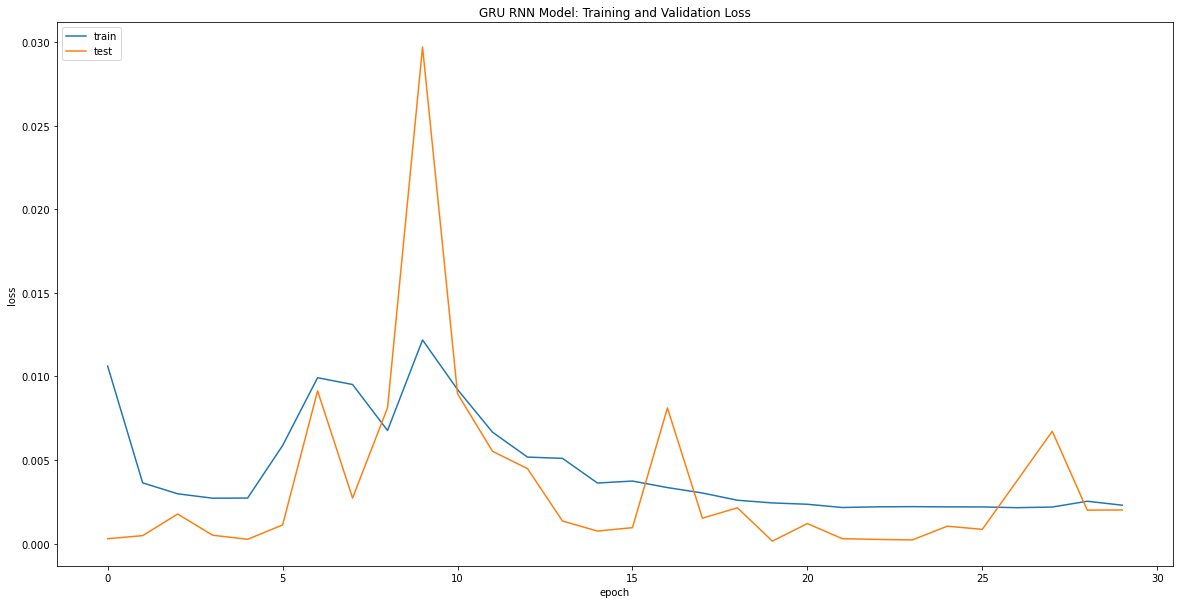

In [41]:

print(gru_history.history.keys())
# summarize history for loss
plt.plot(gru_history.history['loss'])
plt.plot(gru_history.history['val_loss'])
plt.title('GRU RNN Model: Training and Validation Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

22/22 [==============================] - 0s 16ms/step


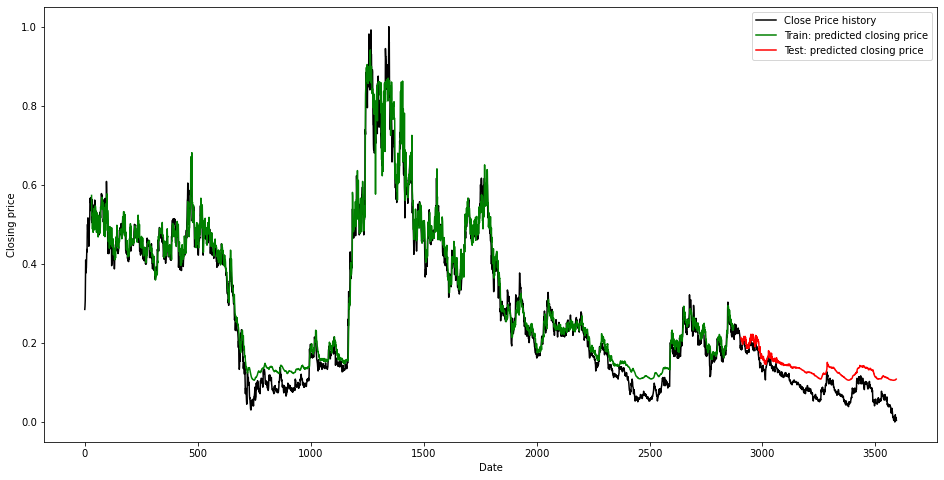

In [42]:

train_predicted_closing_price_gru_model = gru_model.predict(x_train)
math.sqrt(mean_squared_error(y_train,train_predicted_closing_price_gru_model))

test_predicted_closing_price_gru_model=gru_model.predict(x_test)
math.sqrt(mean_squared_error(y_test,test_predicted_closing_price_gru_model))

train_predict_plot = np.empty_like(df['Close'])[:,np.newaxis]
train_predict_plot[:]=np.nan
train_predict_plot[time_step:train_predicted_closing_price_gru_model.shape[0]+time_step]=train_predicted_closing_price_gru_model[np.newaxis,:]
train_predict_plot[time_step:train_predicted_closing_price_gru_model.shape[0]+time_step]

test_predict_plot = np.empty_like(df['Close'])[:,np.newaxis]
test_predict_plot[:]=np.nan
test_predicted_closing_price_gru_model.shape,test_data.shape[0]+train_data.shape[0]
test_predict_plot[train_data.shape[0]+time_step:-1]=test_predicted_closing_price_gru_model[np.newaxis,:]
# test_predict_plot[time_step:test_predicted_closing_price_model1.shape[0]+time_step]


df['train_predicted_gru']=train_predict_plot
df['test_predicted_gru']=test_predict_plot


plt.figure(figsize=(16,8))
plt.plot(df["Close"],label='Close Price history',color='black')
plt.plot(df['train_predicted_gru'],color="green",label='Train: predicted closing price')
plt.plot(df['test_predicted_gru'],color="red",label='Test: predicted closing price')


plt.xlabel("Date");
plt.ylabel("Closing price"); 
plt.legend();